   ## **Capstone Project - The Battle of the Neighborhoods (Week 2)**
   ### **Applied Data Science Capstone by IBM/Coursera**
   #### **Presented by Anand Joshi**

### Business Problem
A leading Personal and Auto Insurance company based in Canada with a significant market share in Toronto city is lately facing a higher claim rates by its customers. This has resulted into lower profits, higher insurance premiums and customer dissatisfaction. The CEO of company would like to carry out a Poof of Concept (PoC) using readily available Data Science & Machine Learning tools, a popular location technology API and most importantly leveraging the publicly available crime data.

#### The key success factors of this PoC are:
- to identify a minimum of 6 neighbourhoods in Toronto city having highest and lowest Crime rates
- successful integration of publicly available data sources on Crime Rates and location mapping technology
- identify unknown clusters or data patterns of crimes which visually may not be identifiable
- enable the Insurance company to offer a targeted insurance premium based on the neighbourhood in which customer lives or does the business.

#### High-level approach
1. use open source and freely available data science and machine learning tools like Python, Juypter Notebook, Sci-kit learn ML library and Github (a code hosting platform for version control and collaboration.)<br>
2. use publicly available Crime data using Toronto Police Service - Public Safety Data Portal
3. identify top Toronto neighbourhood using ForeSquare API (a popular location Technology provider)
4. from this list of top neighbourhoods the list is augmented with additional geographical data 
5. present the historical crimes within a predetermined distance of all neighbourhoods are obtained 
6. a map is presented to the to the CIO showing the selected neighbourhoods and crime statistics of the area. 
7. future probability of a crime happening near or around the selected top sites is also presented to the user

#### Target Audience
This solution is targeted at the CIO of the Insurance company and the Customers to explains the reasons how premiums are calculated and why it varies based on the neighbourhood. This approach may of interest to other Insurance Companies encountering similar business challenge.

### Data

#### Description of the data and its sources  
The focus of this PoC is on Toronto so the key data sources are explored locally. We will be using the below datasets for analysing Toronto city: 

#### Data 1 This is a list of postal codes in Canada where the first letter is M. Postal codes beginning with M are located within the city of Toronto in the province of Ontario. This dataset exists for free on the web. Link to the dataset is: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M 

To create the below (df) dataframe: The dataframe will consist of three columns: PostalCode, Borough, and Neighbourhood Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned. More than one neighbourhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighbourhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighbourhoods separated with a comma as shown in row 11 in the above table. If a cell has a borough but a Not assigned neighbourhood, then the neighbourhood will be the same as the borough. So, for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighbourhood columns will be Queen's Park.  
 
There are a total 103 unique postal coded with one or more Boroughs and Neighbourhoods. 
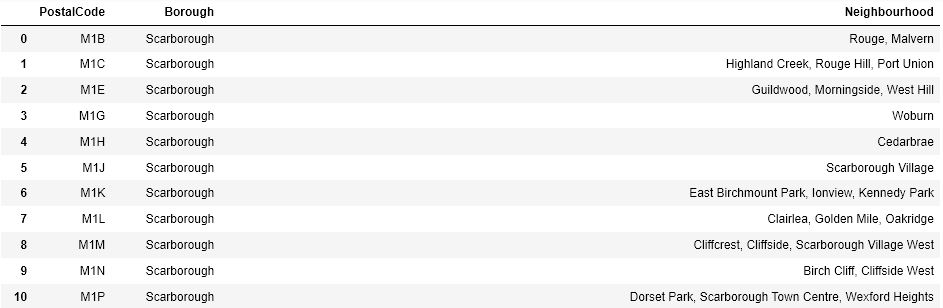
 
#### Data 2 : Second data source is the Geospatial to get the latitude and the longitude coordinates of each neighbourhood in a CSV format from http://cocl.us/Geospatial_data. The following screen shot lists top 10 entries after the file is loaded into a DataFrame. 
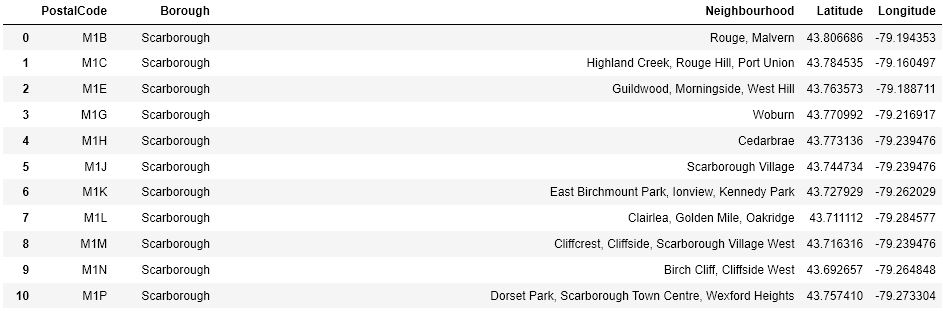

#### Data 3 : The third data source is Toronto Neighbourhood Crime Rates related details from 2014 to 2018 available at Toronto Police Service: Public Safety Data Portal: http://data.torontopolice.on.ca/datasets/neighbourhood-crime-ratesboundary-file-/data?geometry=-80.686%2C43.542%2C-78.346%2C43.89 
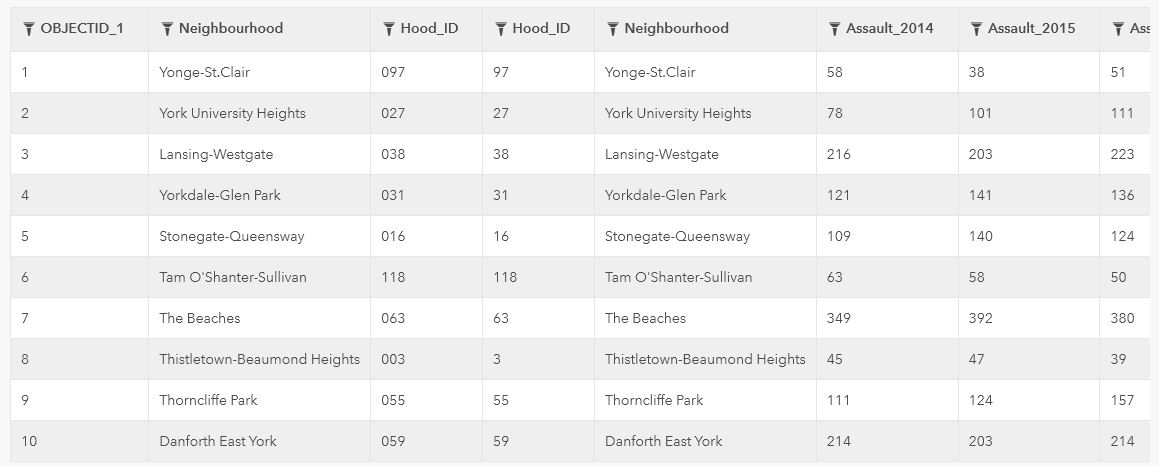
 
#### Data 4 : Fourth data source is Foursquare to explore the neighbourhoods and segment them. Foursquare is a Location Technology Company which provide an API and Data to further drill down the neighbourhoods of Toronto: 
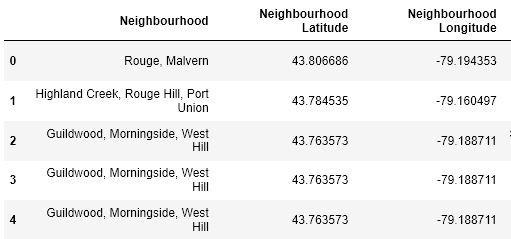

In [1]:
# setup import
import pandas as pd 
import io
import sys
import json # library to handle JSON files
import requests # library to handle requests
import numpy as np # library to handle data in a vectorized manner

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
#!conda install -c python-matplotlib 
import seaborn as sns                       #visualisation
sns.set(color_codes=True)
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt             #visualisation
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
#from IPython.display import HTML, display

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

print('Libraries imported.')

# Pandas options
pd.set_option('display.max_rows', 11)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.width', 1000)
pd.set_option('expand_frame_repr', True)

Libraries imported.


In [2]:
# This Notebook is to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M and persist in a dataframe object.

'''
    To create the below (df) dataframe:
    The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
    Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.More than one neighborhood can exist in one postal code area.
    For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows 
    will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
    If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, 
    the value of the Borough and the Neighborhood columns will be Queen's Park.
'''

# Read the HTML Table from the URL
url = r'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df = pd.read_html(url, header = 0)[0]

# rename the column name
df.rename(columns={"Postcode": "PostalCode"}, inplace=True)

# Only process the cells that have an assigned borough. 
df = df[df.Borough != 'Not assigned']

df = df.groupby(['PostalCode', 'Borough']).agg({'Neighbourhood':lambda x:', '.join(x)}).reset_index()

for index, row in df.iterrows():
    if row['Neighbourhood'] == 'Not assigned':
        row['Neighbourhood'] = row['Borough']

# To get the latitude and the longitude coordinates of each neighborhood.
s=requests.get("http://cocl.us/Geospatial_data").content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))

# rename the first column to allow merging dataframes on Postcode
c.columns = ['PostalCode', 'Latitude', 'Longitude']
df = pd.merge(c, df, on='PostalCode')

# reorder column names and show the dataframe
toronto_df = df[['PostalCode', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude']]
toronto_df

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richview Gardens, St. Phillips",43.688905,-79.554724
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",43.739416,-79.588437


### **Load Toronto_Neighbourhood_Crime_Rates_Boundary_File into the dataframe**

In [3]:
#fileName = 'Toronto_Neighbourhood_Crime_Rates_Boundary_File_.csv'
fileName = r'Toronto_Neighbourhood_Crime_Rates_Boundary_File_.csv'

df_crime = pd.read_csv(fileName, sep=',', index_col=0, header=0)
df_crime


,Neighbourhood_Crime_Rates_Neigh,Neighbourhood_Crime_Rates_Hood_,Hood_ID,Neighbourhood,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_AVG,Assault_CHG,Assault_Rate_2018,Auto_Theft_2014,Auto_Theft_2015,Auto_Theft_2016,Auto_Theft_2017,Auto_Theft_2018,AutoTheft_AVG,AutoTheft_CHG,AutoTheft_Rate_2018,BreakandEnter_2014,BreakandEnter_2015,BreakandEnter_2016,BreakandEnter_2017,BreakandEnter_2018,BreakandEnter_AVG,BreakandEnter_CHG,BreakandEnter_Rate_2018,Robbery_2014,Robbery_2015,Robbery_2016,Robbery_2017,Robbery_2018,Robbery_AVG,Robbery_CHG,Robbery_Rate_2018,Theft_Over_2014,Theft_Over_2015,Theft_Over_2016,Theft_Over_2017,Theft_Over_2018,TheftOver_AVG,TheftOver_CHG,TheftOver_Rate_2018,Homicide_2014,Homicide_2015,Homicide_2016,Homicide_2017,Homicide_2018,Homicide_AVG,Homicide_CHG,Homicide_Rate_2018,Population,Shape__Area,Shape__Length
OBJECTID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Yonge-St.Clair,97,97,Yonge-St.Clair,58,38,51,46,61,50.8,33%,1912.8,28,32,22,46,69,39.4,50%,2163.7,29,16,28,32,23,25.6,-28%,721.2,12,25.0,14,21,19,18.2,-10%,595.8,3,6,4.0,6,3.0,4.40,-50%,94.1,0,0,0,0,0,NaN,NaN,0.0,3189,1.161315e+06,5873.270507
2,York University Heights,27,27,York University Heights,78,101,111,120,138,109.6,15%,375.4,16,13,8,19,23,15.8,21%,62.6,43,59,61,34,52,49.8,53%,141.4,28,22.0,23,31,15,23.8,-52%,40.8,4,4,3.0,6,2.0,3.80,-67%,5.4,1,0,2,0,1,1.3,NaN,2.7,36764,1.324666e+07,18504.777616
3,Lansing-Westgate,38,38,Lansing-Westgate,216,203,223,226,197,213.0,-13%,1923.5,21,25,23,36,22,25.4,-39%,214.8,43,78,72,73,52,63.6,-29%,507.7,81,53.0,49,43,41,53.4,-5%,400.3,8,4,7.0,2,6.0,5.40,200%,58.6,0,0,0,0,0,NaN,NaN,0.0,10242,5.346186e+06,11112.109419
4,Yorkdale-Glen Park,31,31,Yorkdale-Glen Park,121,141,136,124,127,129.8,2%,696.5,47,27,25,30,28,31.4,-7%,153.6,83,50,65,31,56,57.0,81%,307.1,42,32.0,22,18,35,29.8,94%,192.0,8,6,8.0,10,13.0,9.00,30%,71.3,1,1,1,1,2,1.2,100%,11.0,18233,6.038326e+06,10079.426837
5,Stonegate-Queensway,16,16,Stonegate-Queensway,109,140,124,112,128,122.6,14%,576.4,20,17,22,14,41,22.8,193%,184.6,48,37,34,37,41,39.4,11%,184.6,33,22.0,41,35,36,33.4,3%,162.1,10,3,4.0,5,4.0,5.20,-20%,18.0,1,0,0,0,0,1.0,NaN,0.0,22207,7.946202e+06,11853.189803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,Pleasant View,46,46,Pleasant View,261,270,278,252,260,264.2,3%,1365.4,35,45,57,44,53,46.8,20%,278.3,33,35,29,40,36,34.6,-10%,189.1,34,40.0,61,42,39,43.2,-7%,204.8,6,6,9.0,5,11.0,7.40,120%,57.8,0,0,0,0,0,NaN,NaN,0.0,19042,2.967493e+06,7944.829782
137,Wychwood,94,94,Wychwood,70,84,67,74,86,76.2,16%,1162.6,4,5,9,3,10,6.2,233%,135.2,20,13,40,20,31,24.8,55%,419.1,18,6.0,10,8,9,10.2,13%,121.7,3,5,3.0,2,NaN,3.25,-100%,0.0,0,0,0,0,0,NaN,NaN,0.0,7397,1.682111e+06,5435.022062
138,Leaside-Bennington,56,56,Leaside-Bennington,87,104,83,134,102,102.0,-24%,502.3,31,29,39,55,49,40.6,-11%,241.3,20,28,22,18,41,25.8,128%,201.9,23,12.0,18,27,17,19.4,-37%,83.7,1,9,1.0,7,11.0,5.80,57%,54.2,0,1,0,0,0,1.0,NaN,0.0,20308,4.784766e+06,14836.618542


### Exploratory data analysis of Toronto Crime Rates.  
#### Subselect the features of interest and group them by Neighbourhood

In [4]:
df_all_crime_avg = df_crime.groupby(['Neighbourhood'])['Assault_AVG','AutoTheft_AVG','BreakandEnter_AVG','Robbery_AVG','TheftOver_AVG'].apply(lambda x : x.astype(int).sum()) #.reset_index()
df_all_crime_avg['Total'] = df_all_crime_avg['Assault_AVG'] + df_all_crime_avg['AutoTheft_AVG'] + df_all_crime_avg['BreakandEnter_AVG'] + df_all_crime_avg['Robbery_AVG'] + df_all_crime_avg['TheftOver_AVG']
df_all_crime_avg.sort_values(by=['Total'],ascending=False , inplace=True)
df_all_crime_avg = df_all_crime_avg.reset_index()
df_all_crime_avg

,Neighbourhood,Assault_AVG,AutoTheft_AVG,BreakandEnter_AVG,Robbery_AVG,TheftOver_AVG,Total
0,Black Creek,812,40,189,180,38,1259
1,Cliffcrest,758,49,214,64,48,1133
2,Ionview,275,336,131,75,49,866
3,Palmerston-Little Italy,426,23,126,126,18,719
4,Willowridge-Martingrove-Richview,489,21,107,57,37,711
...,...,...,...,...,...,...,...
135,Pelmo Park-Humberlea,37,5,13,5,1,61
136,New Toronto,36,5,14,4,1,60
137,Bay Street Corridor,17,11,22,5,2,57
138,Eglinton East,22,3,16,2,3,46


### **Checking the types of data**

In [5]:
df_all_crime_avg.dtypes

Neighbourhood        object
Assault_AVG           int64
AutoTheft_AVG         int64
BreakandEnter_AVG     int64
Robbery_AVG           int64
TheftOver_AVG         int64
Total                 int64
dtype: object

### Check for missing or null values

In [6]:
print(df_all_crime_avg.isnull().sum())

Neighbourhood        0
Assault_AVG          0
AutoTheft_AVG        0
BreakandEnter_AVG    0
Robbery_AVG          0
TheftOver_AVG        0
Total                0
dtype: int64


### Detecting Outliers
An outlier is a point or set of points that are different from other points. Sometimes they can be very high or very low. It's often a good idea to detect and remove the outliers. Because outliers are one of the primary reasons for resulting in a less accurate model. Hence it's a good idea to remove them. The outlier detection and removing that I am going to perform is called IQR score technique. I limit this exercise to only two features.

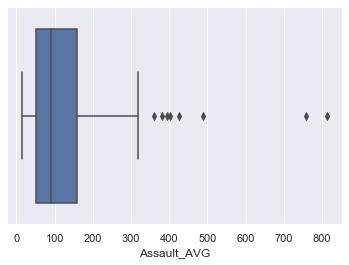

In [7]:
sns.boxplot(x=df_all_crime_avg['Assault_AVG'])

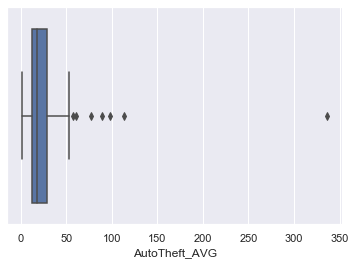

In [8]:
sns.boxplot(x=df_all_crime_avg['AutoTheft_AVG'])

In [9]:
Q1 = df_all_crime_avg.quantile(0.25)
Q3 = df_all_crime_avg.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Assault_AVG          106.75
AutoTheft_AVG         17.00
BreakandEnter_AVG     35.75
Robbery_AVG           23.00
TheftOver_AVG          5.00
Total                166.75
dtype: float64


### Plot different features against one another
#### Heat Maps

,Assault_AVG,AutoTheft_AVG,BreakandEnter_AVG,Robbery_AVG,TheftOver_AVG,Total
Assault_AVG,1.000000,0.339573,0.815759,0.875712,0.767013,0.968372
AutoTheft_AVG,0.339573,1.000000,0.432230,0.418552,0.639910,0.533175
BreakandEnter_AVG,0.815759,0.432230,1.000000,0.736194,0.853362,0.886730
Robbery_AVG,0.875712,0.418552,0.736194,1.000000,0.660193,0.900254
TheftOver_AVG,0.767013,0.639910,0.853362,0.660193,1.000000,0.861734
Total,0.968372,0.533175,0.886730,0.900254,0.861734,1.000000


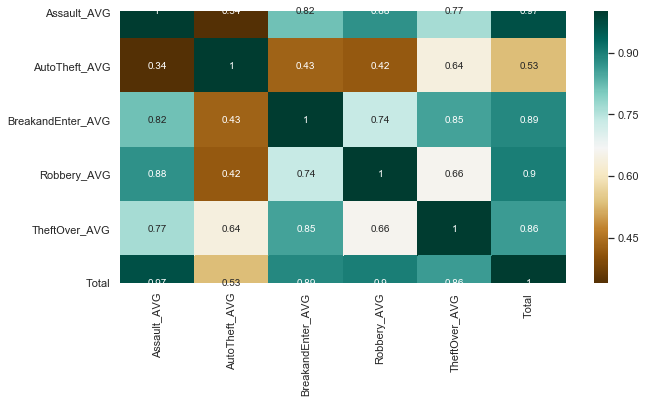

In [10]:
plt.figure(figsize=(10,5))
c= df_all_crime_avg.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

### Scatterplot
We generally use scatter plots to find the correlation between two variables. Here the scatter plots are plotted between AutoTheft and Roberry and we can see the plot below. With the plot given below, we can easily draw a trend line. These features provide a good scattering of points.

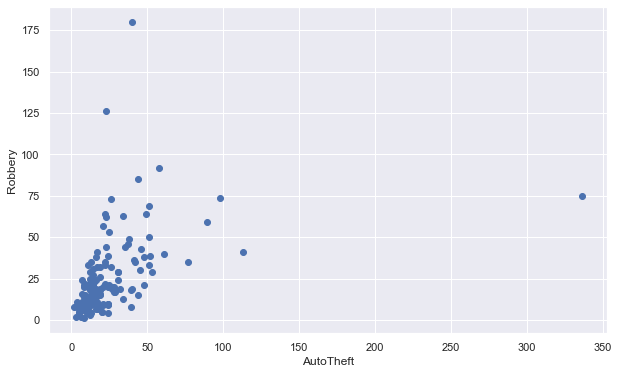

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df_all_crime_avg['AutoTheft_AVG'], df_all_crime_avg['Robbery_AVG'])
ax.set_xlabel('AutoTheft')
ax.set_ylabel('Robbery')
plt.show()

## Foursqare API

In [12]:
# @hidden_cell
CLIENT_ID = 'WAZL32SHGDNXD33KC5E1TCORS1EKWTKS1FNDWE3OXDA3L2HS' # your Foursquare ID
CLIENT_SECRET = 'XXBGQM2MS2LOIX2LZU0IN4RMYQH3GBCWWRARPDYHOPPHXOIE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### Use geopy library to get Lat and Long for Toronto. In order to define an instance of geocoder, we need to define a user agent. Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them. Define Foursquare Credentials and Version

#### **Get the neighborhood's latitude and longitude values.**

In [13]:
geolocator = Nominatim(user_agent="to_explorer",timeout=3)
for index, row in df_all_crime_avg.iterrows():
    address = df_all_crime_avg.loc[index, 'Neighbourhood'] + ', Toronto, ON'
    location = geolocator.geocode(address)
    if not pd.isnull(location):
        try:
            latitude = location.latitude
            longitude = location.longitude
            df_all_crime_avg.loc[index, 'Latitude'] = latitude # neighborhood latitude value
            df_all_crime_avg.loc[index, 'Longitude'] = longitude # neighborhood longitude value
            
        except OSError as err:
            print("OS error: {0}".format(err))
        except ValueError:
            print("Could not convert data to an integer.")
        except:
            #print(str(address) + ' ' + str(latitude) + ' ' + str(longitude))
            #print("Unexpected error:", sys.exc_info()[0])
            True #print()

In [14]:
df_all_crime_avg = df_all_crime_avg.dropna()

#### Create a map of Toronto with neighbourhood superimposed on top. We will highlisht top 6 Neighbourhoods with a highest and lowest crime rates. The highest crime rate neighbourhood is with Red circle, lowest with Blue and the rest in Yellow circles

In [15]:
# create map of Toronto using latitude and longitude values
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label, total in zip(df_all_crime_avg['Latitude'], df_all_crime_avg['Longitude'], df_all_crime_avg['Neighbourhood'], df_all_crime_avg['Total']):
    if label in ('Black Creek', 'Cliffcrest', 'Ionview'):  
        label = folium.Popup(label + ' (' + str(total) + ') ', parse_html=True) 
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3187cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto) 
    elif label in ('Bay Street Corridor', 'Eglinton East', 'Danforth'):
        label = folium.Popup(label + ' (' + str(total) + ') ', parse_html=True) 
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3187cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto) 
    else:
        label = folium.Popup(label + ' (' + str(total) + ') ', parse_html=True) 
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3188cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto) 
        
display(map_toronto)

The geograpical coordinate of Toronto City are 43.653963, -79.387207.


#### Foursquare
Lets identify the police stations near the neighbourhoods idetified above

In [16]:
# Category IDs corresponding to Poice Stations were taken from Foursquare web site (https://developer.foursquare.com/docs/resources/categories):

gov_category = '4bf58dd8d48988d126941735' # 'Goverment Building' category for all poice venues

toronto_police_categories = ['4bf58dd8d48988d12e941735']

def get_venues_near_location(lat, lon, category, client_id, client_secret, radius=500, limit=100):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, client_secret, VERSION, lat, lon, category, radius, limit)
    #print(url)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   get_categories(item['venue']['categories']),
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   format_address(item['venue']['location']),
                   item['venue']['location']['distance']) for item in results]        
    except:
        venues = []
    return venues

In [17]:
import pickle
fileName = r'C:\Users\anand\PycharmProjects\Capstone\TorontoPoliceStationCoordinates.csv'
TPC = pd.read_csv(fileName, sep=',', index_col=False, header=0)

with open('police_stns_loc.pkl', 'wb') as f:
        pickle.dump(TPC, f)
# rename the column name
TPC

,Division,Address,Latitude,Longitude
0,11 Division,2054 Davenport Rd.,43.67108,-79.46083
1,12 Division,200 Trethewey Dr.,43.69458,-79.48688
2,13 Division,1435 Eglinton Av. W.,43.69833,-79.43668
3,14 Division,350 Dovercourt Rd.,43.65130,-79.42598
4,51 Division,51 Parliament St.,43.65195,-79.36214
...,...,...,...,...
9,23 Division,5230 Finch Av. W,43.74387,-79.58352
10,31 Division,40 Norfinch Dr.,43.75675,-79.52747
11,32 Division,30 Ellerslie Av.,43.77173,-79.41509
12,33 Division,50 Upjohn Rd.,43.75108,-79.35007


In [18]:
# Let's now go over our neighborhood locations and get nearby police statios; we'll also maintain a dictionary of all found police statios 
import pickle
def get_police_station(lats, lons):
    police_station = {}
    location_police_station = []
    print('Obtaining venues around candidate locations:', end='')
    for lat, lon, label in zip(df_all_crime_avg['Latitude'], df_all_crime_avg['Longitude'], df_all_crime_avg['Neighbourhood']):
        # Using radius=350 to meke sure we have overlaps/full coverage so we don't miss any police station (we're using dictionaries to remove any duplicates resulting from area overlaps)
        venues = get_venues_near_location(lat, lon, gov_category, CLIENT_ID, CLIENT_SECRET) #, radius=350, limit=500)
        #print(venues)
        area_police_station = []
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            x, y = lonlat_to_xy(venue_latlon[1], venue_latlon[0])
            police_station = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], venue_address, venue_distance, x, y)
            area_police_station.append(police_station)
            police_station[venue_id] = police_station        
        
        print(' .', end='')
    print(' done.')
    return police_station, location_police_station

#police_station, location_police_station = get_police_station(latitude, longitude)

# Try to load from local file system in case we did this before
police_station = {}
location_police_station = []
loaded = False
try:
    with open('police_stns_loc.pkl', 'rb') as f:
        location_police_station  = pickle.load(f)
    print('Police Location data in pickle loaded from disk.')
    loaded = True
except:
    pass

# If load failed use the Foursquare API to get the data
if not loaded:
    police_station, location_police_station = get_police_station(latitude, longitude)
    
    # Let's persists this in local file system
    with open('police_stns_loc1.pkl', 'wb') as f:
        pickle.dump(location_police_station, f)
    

Police Location data in pickle loaded from disk.


In [19]:
location_police_station

,Division,Address,Latitude,Longitude
0,11 Division,2054 Davenport Rd.,43.67108,-79.46083
1,12 Division,200 Trethewey Dr.,43.69458,-79.48688
2,13 Division,1435 Eglinton Av. W.,43.69833,-79.43668
3,14 Division,350 Dovercourt Rd.,43.65130,-79.42598
4,51 Division,51 Parliament St.,43.65195,-79.36214
...,...,...,...,...
9,23 Division,5230 Finch Av. W,43.74387,-79.58352
10,31 Division,40 Norfinch Dr.,43.75675,-79.52747
11,32 Division,30 Ellerslie Av.,43.77173,-79.41509
12,33 Division,50 Upjohn Rd.,43.75108,-79.35007


In [20]:
for lat, lng, label in zip(location_police_station['Latitude'], location_police_station['Longitude'], location_police_station['Division']):
    label = folium.Popup(label, parse_html=True) 
    folium.Marker(
        [lat, lng],
        popup=label,color='',).add_to(map_toronto) 
display(map_toronto)

## Results and Conclusion

This concludes our analysis. We have highligted Toronto neighbourhood with the highest to lowest crimes and nearby Police Stations. It is interesting to observe high crime neighbourhoods in peripheral areas on Toronto city and downtown core is having moderate crime rates. The Insurance company can factor in the distribuion of the crime rates and location of the police stations for determining the premium rates.

All key success factors of this PoC are achieved i.e:
1. identify a minimum of 6 neighbourhoods in Toronto city having highest and lowest Crime rates
2. successful integration of publicly available data sources on Crime Rates and location mapping technology
3. identify unknown clusters or data patterns of crimes which visually may not be identifiable
4. enable the Insurance company to offer a targeted insurance premium based on the neighbourhood in which customer lives or does the business.

Final decision of adopting Data Science and ML tools, and use of publicly avaialble data sources will be made by stakeholders based on specific characteristics of neighborhoods and crime rates, taking into consideration additional factors like police station location etc.